In [1]:
import pandas as pd
import numpy as np
import json

import matplotlib as mpl
from matplotlib import pyplot as plt

In [2]:
from log_parser import process_file


### parameters

In [3]:
_fname = "../replays/log4.log"
_time_step = 100
_symbols = ["PEARLS", "BANANAS"]
_products = ["PEARLS", "BANANAS"]


### pre processing

In [4]:
# load data from file

obj = process_file(_fname)
df = pd.DataFrame(obj)

listings = pd.DataFrame(df["listings"][0])
df = df.drop("listings", axis=1)
df = df.rename({
    "timestamp": "time",
    "order_depths": "book",
}, axis=1)

Reading from input file ../replays/log4.log


In [5]:
# add turns (vs time)

all_times = df["time"]
turn2time_map = all_times.to_dict()
time2turn_map = {v: k for k, v in turn2time_map.items()}
df["turn"] = df["time"].map(time2turn_map)

df.index = df["turn"]

In [6]:
def process_book(book):
    best_buy = {}
    best_sell = {}
    ret = {}
    cols = ["price", "quantity"]
    for sym in _symbols:
        orders = {
            "buy": pd.DataFrame(columns=cols),
            "sell": pd.DataFrame(columns=cols),
        }
        
        if sym in book:
            if "buy_orders" in book[sym]:
                orders["buy"] = pd.DataFrame(book[sym]["buy_orders"].items(), columns=cols).sort_values(by="price", ascending=False)
            if "sell_orders" in book[sym]:
                orders["sell"] = pd.DataFrame(book[sym]["sell_orders"].items(), columns=cols).sort_values(by="price", ascending=True)
        
        ret[sym] = orders
        
        if len(orders["buy"]) > 0:
            best_buy[sym] = orders["buy"]["price"][0]
        else:
            best_buy[sym] = np.nan
            
        if len(orders["sell"]) > 0:
            best_sell[sym] = orders["sell"]["price"][0]
        else:
            best_sell[sym] = np.nan
            
        
    return ret, best_buy, best_sell


books = pd.DataFrame(df["book"].apply(process_book).to_list(), columns=["book", "best_buy", "best_sell"])
book_tops = books.drop("book", axis=1)

# all book tops
book_tops = pd.concat([book_tops[c].apply(pd.Series).add_suffix(f"_{c}") for c in book_tops.columns], axis=1).astype(int)

for sym in _symbols:
    book_tops[f"{sym}_mid"] = (book_tops[f"{sym}_best_buy"] + book_tops[f"{sym}_best_sell"]) / 2
    book_tops[f"{sym}_spread"] = book_tops[f"{sym}_best_sell"] - book_tops[f"{sym}_best_buy"]
    assert book_tops[f"{sym}_spread"].all() > 0

# sort columns
book_tops = book_tops.reindex(sorted(book_tops.columns), axis=1)


# all books
books = books["book"]

In [7]:
num_data = len(book_tops.dropna())
num_data_dropna = len(book_tops)

print(f"Orig count: {num_data}")
print(f"dropna count: {num_data_dropna}")
print(f"nan count: {num_data - num_data_dropna}")

Orig count: 1998
dropna count: 1998
nan count: 0


In [8]:
def flatten_trades(df, col, is_me):
    # get market trades

    data = []
    for index, row  in df.iterrows():
        all_trades = list(row[col].values())
        for sym_trades in all_trades:
            for trade in sym_trades:
                trade["time"] = row["time"] # fill time
                trade["turn"] = row["turn"] # fill time
            data += sym_trades

    df = pd.DataFrame(data)
    df = df.rename({"timestamp": "order_time"}, axis=1)
    
    # calculate info about my trades
    df["is_me"] = is_me
    df["my_action"] = np.where(df["buyer"] == "SUBMISSION", "buy", None)
    df["my_action"] = np.where(df["seller"] == "SUBMISSION", "sell", None)
    df["my_quantity"] = df["quantity"] * df["is_me"].astype(int) * (2 * (df["my_action"] == "buy").astype(int) - 1)
    
    return df

In [9]:
# get my_trades, market_trades, and trade_df (all_trades)

market_trades = flatten_trades(
    df, 
    "market_trades", 
    is_me=False
).sort_values(by="time")

my_trades = flatten_trades(
    df, 
    "own_trades", 
    is_me=True
).sort_values(by="time")


# filter market trades (only keep those where order_time = fill_time)
market_trades = market_trades[market_trades["time"] == market_trades["order_time"]]

# filter my_trades (only keep those where fill_time = order_time + 100)
my_trades = my_trades[my_trades["time"] == my_trades["order_time"] + _time_step]


trade_df = pd.concat([market_trades, my_trades])
trade_df = trade_df.sort_values(by="time").reset_index(drop=True)
trade_df = trade_df.drop(["order_time", "buyer", "seller"], axis=1)

my_trades = trade_df[trade_df["is_me"]]
market_trades = trade_df[~trade_df["is_me"]]


In [10]:
# get my_positions
my_positions = pd.DataFrame(list(df["position"])).fillna(0)

# add any products of zero quantity
for prod in _products:
    if prod not in my_positions:
        my_positions[prod] = 0
        
my_positions[["time", "turn"]] = df[["time", "turn"]]
my_positions = my_positions.sort_values(by="time")

# add cash to my_positions
cash_data = []
cur_cash = 0
cur_time = turn2time_map[0]
for index, row in my_trades.iterrows():
    row_time = row["time"]
    while cur_time < row["time"]:
        cash_data += [cur_cash]
        cur_time = turn2time_map[len(cash_data)]
        
    cur_cash += -1 * row["price"] * row["my_quantity"]

# add for remaining turns
while cur_time < max(turn2time_map.values()):
    cash_data += [cur_cash]
    cur_time = turn2time_map[len(cash_data)]
cash_data += [cur_cash]

# add to my_positions
my_positions["cash"] = cash_data






### Data analysis/vis
- for info about trades:
    - `trade_df` (all trades)
    - `my_trades` (our trades only)
    - `market_trades` (other people's trades only, not our trades)
- for info about our positions
    - `my_positions`

### todo:
- my_positions
    - calculate approx product price per turn
    - calculate total inventory value + total net worth (aka pnl)
- visualize book

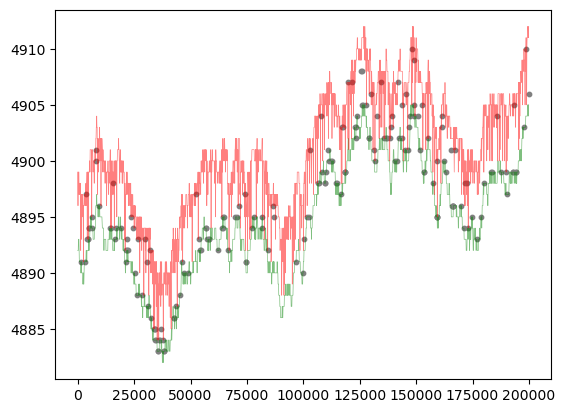

In [11]:
# plot trades

sym = "BANANAS"

plt_df = trade_df[trade_df["symbol"] == sym]

my_buys = plt_df[plt_df["my_quantity"] > 0]
my_sells = plt_df[plt_df["my_quantity"] < 0]
their_trades = plt_df[plt_df["my_quantity"] == 0]

plt.scatter(my_buys["time"], my_buys["price"], c="green", s=25)
plt.scatter(my_sells["time"], my_sells["price"], c="red", s=25)
plt.scatter(their_trades["time"], their_trades["price"], c="gray", s=10)


# plot book
plt.plot(df["time"], book_tops[f"{sym}_best_buy"], c="green", alpha=0.5, linewidth=0.5)
plt.plot(df["time"], book_tops[f"{sym}_best_sell"], c="red", alpha=0.5, linewidth=0.5)

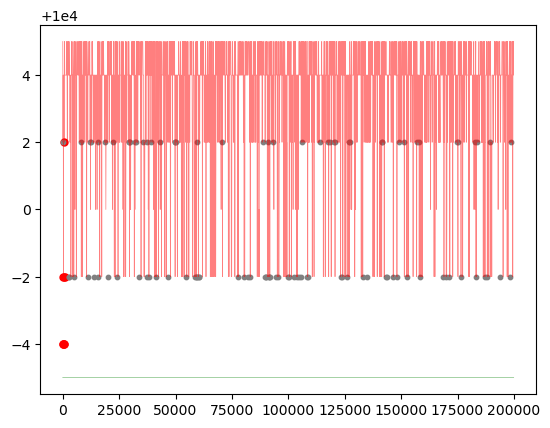

In [12]:
# plot trades

sym = "PEARLS"

plt_df = trade_df[trade_df["symbol"] == sym]

my_buys = plt_df[plt_df["my_quantity"] > 0]
my_sells = plt_df[plt_df["my_quantity"] < 0]
their_trades = plt_df[plt_df["my_quantity"] == 0]

plt.scatter(my_buys["time"], my_buys["price"], c="green", s=25)
plt.scatter(my_sells["time"], my_sells["price"], c="red", s=25)

plt.scatter(their_trades["time"], their_trades["price"], c="gray", s=10)


# plot book
plt.plot(df["time"], book_tops[f"{sym}_best_buy"], c="green", alpha=0.5, linewidth=0.5)
plt.plot(df["time"], book_tops[f"{sym}_best_sell"], c="red", alpha=0.5, linewidth=0.5)

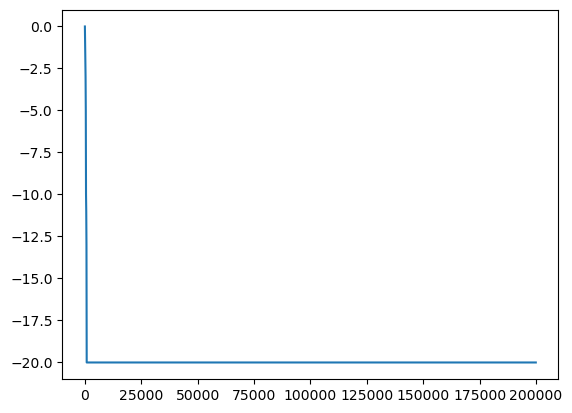

In [13]:
# plot my positions in each product

plt.plot(my_positions["time"], my_positions["PEARLS"])

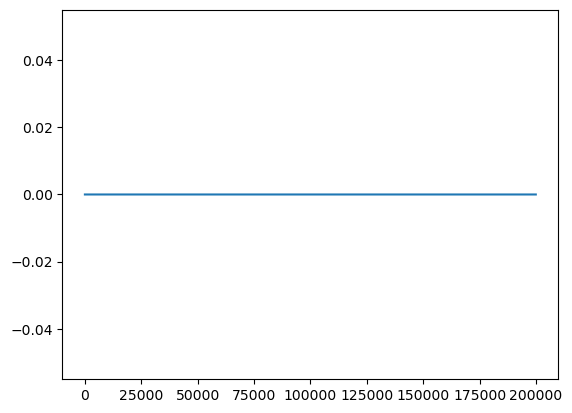

In [14]:
# plot my positions in each product

# plt.bar(my_positions["time"], my_positions["BANANAS"])
plt.plot(my_positions["time"], my_positions["BANANAS"])

In [15]:
my_positions

,PEARLS,BANANAS,time,turn,cash
0,0.0,0,0,0,0.0
1,-1.0,0,100,1,9998.0
2,-2.0,0,200,2,19994.0
3,-3.0,0,300,3,29990.0
4,-5.0,0,400,4,49982.0
...,...,...,...,...,...
1993,-20.0,0,199500,1993,199952.0
1994,-20.0,0,199600,1994,199952.0
1995,-20.0,0,199700,1995,199952.0
1996,-20.0,0,199800,1996,199952.0


In [16]:
set(i for i in range(0, 200000, 100)) - set(df["time"])

{10800, 173500}

In [17]:
df["book"][0]["BANANAS"]

{'buy_orders': {'4892': 30, '4893': 1}, 'sell_orders': {'4899': -30}}

In [18]:
listings

,BANANAS,PEARLS
denomination,1,1
product,BANANAS,PEARLS
symbol,BANANAS,PEARLS


In [19]:
df

,market_trades,observations,book,own_trades,position,time,turn
turn,,,,,,,
0,{},{},"{'BANANAS': {'buy_orders': {'4892': 30, '4893'...",{},{},0,0
1,"{'PEARLS': [{'buyer': '', 'price': 10002.0, 'q...",{},"{'BANANAS': {'buy_orders': {'4892': 31}, 'sell...","{'PEARLS': [{'buyer': '', 'price': 9998.0, 'qu...",{'PEARLS': -1},100,1
2,"{'PEARLS': [{'buyer': '', 'price': 10002.0, 'q...",{},"{'BANANAS': {'buy_orders': {'4892': 22}, 'sell...","{'PEARLS': [{'buyer': '', 'price': 9996.0, 'qu...",{'PEARLS': -2},200,2
3,"{'PEARLS': [{'buyer': '', 'price': 10002.0, 'q...",{},"{'BANANAS': {'buy_orders': {'4893': 25}, 'sell...","{'PEARLS': [{'buyer': '', 'price': 9996.0, 'qu...",{'PEARLS': -3},300,3
4,"{'PEARLS': [{'buyer': '', 'price': 9998.0, 'qu...",{},"{'BANANAS': {'buy_orders': {'4893': 25, '4894'...","{'PEARLS': [{'buyer': '', 'price': 9996.0, 'qu...",{'PEARLS': -5},400,4
...,...,...,...,...,...,...,...
1993,"{'BANANAS': [{'buyer': '', 'price': 4910.0, 'q...",{},"{'BANANAS': {'buy_orders': {'4905': 22}, 'sell...","{'PEARLS': [{'buyer': '', 'price': 9998.0, 'qu...",{'PEARLS': -20},199500,1993
1994,"{'BANANAS': [{'buyer': '', 'price': 4905.0, 'q...",{},"{'BANANAS': {'buy_orders': {'4905': 28}, 'sell...","{'PEARLS': [{'buyer': '', 'price': 9998.0, 'qu...",{'PEARLS': -20},199600,1994
1995,"{'BANANAS': [{'buyer': '', 'price': 4905.0, 'q...",{},"{'BANANAS': {'buy_orders': {'4904': 28, '4905'...","{'PEARLS': [{'buyer': '', 'price': 9998.0, 'qu...",{'PEARLS': -20},199700,1995
